In [9]:
import pandas as pd
import gensim
import gensim.corpora as corpora
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Chargement des données
df = pd.read_csv("QueryResults.csv")
df.head()

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,<c#><datetime><time><datediff><relative-time-s...,11,1655,205591,NaN,42
1,"Message ""Support for password authentication w...",<p>I got this error on my console when I tried...,<git><github><github-api><git-pull><personal-a...,68775869,1809,2439560,NaN,53
2,How to get first N number of elements from an ...,<p>I am working with Javascript(ES6) /FaceBook...,<javascript><arrays><filtering><slice><extract>,34883068,1206,1420494,NaN,13
3,"Git is not working after macOS update (""xcrun:...","<p>I updated to the latest OS, and/or restarte...",<xcode><git><macos><command-line><terminal>,52522565,3509,1500843,NaN,41
4,How do I copy a folder from remote to local us...,<p>How do I copy a folder from remote to local...,<shell><ssh><command-line><copy><scp>,11304895,3573,3778083,NaN,17


In [10]:
# 2. Prétraitement NLP des titres de questions
import spacy

# Charger le modèle spaCy anglais
nlp = spacy.load("en_core_web_sm")

# Sélection des titres non nuls
texts_raw = df['Title'].dropna().tolist()

# Fonction de prétraitement avec spaCy
def preprocess_spacy(texts):
    processed = []
    for doc in nlp.pipe(texts, disable=["ner", "parser"]):  # plus rapide en désactivant les composants inutiles
        tokens = [
            token.lemma_ for token in doc
            if token.is_alpha                # mots alphabétiques uniquement
            and not token.is_stop            # enlever les stop words
            and len(token) > 2               # retirer les mots trop courts
        ]
        processed.append(tokens)
    return processed

# Appliquer le prétraitement
texts = preprocess_spacy(texts_raw)

In [11]:
# 3. Construction du dictionnaire et du corpus pour LDA

# Créer le dictionnaire (chaque mot = ID unique)
id2word = corpora.Dictionary(texts)

# Créer le corpus (chaque document devient un sac de mots)
corpus = [id2word.doc2bow(text) for text in texts]

In [12]:
# 4. Modélisation avec LDA

# Entraîner le modèle LDA
lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=5,
    random_state=42,
    passes=10,
    chunksize=100,
    alpha='auto',
    per_word_topics=True
)

# Afficher les mots-clés de chaque topic
print("Mots-clés représentatifs des topics détectés :\n")
for i, topic in lda_model.show_topics(formatted=False):
    keywords = [word for word, _ in topic]
    print(f"Topic {i}: {keywords}")

Mots-clés représentatifs des topics détectés :

Topic 0: ['string', 'Java', 'array', 'text', 'Android', 'SQL', 'character', 'difference', 'object', 'file']
Topic 1: ['use', 'PHP', 'file', 'find', 'key', 'git', 'datum', 'update', 'request', 'difference']
Topic 2: ['select', 'JavaScript', 'jQuery', 'Html', 'local', 'value', 'column', 'row', 'folder', 'browser']
Topic 3: ['file', 'check', 'remove', 'Python', 'list', 'Git', 'repository', 'variable', 'line', 'password']
Topic 4: ['difference', 'element', 'change', 'Undefined', 'notice', 'fix', 'undefined', 'fast', 'position', 'HTML']


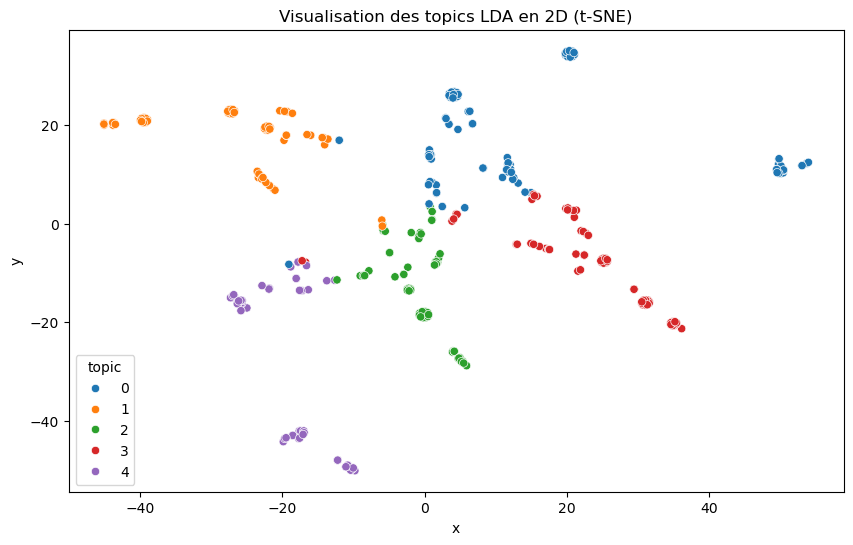

In [14]:
# 5. Création de la matrice des distributions de topics

import numpy as np

# Pour chaque document, obtenir sa distribution de topics (vecteur de probabilités)
topic_distributions = []
for doc_bow in corpus:
    topics = lda_model.get_document_topics(doc_bow)
    dense = [0] * lda_model.num_topics
    for topic_num, prob in topics:
        dense[topic_num] = prob
    topic_distributions.append(dense)

# Convertir en matrice NumPy pour t-SNE
topic_distributions_np = np.array(topic_distributions)

# Appliquer t-SNE sur les distributions de topics
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
tsne_results = tsne.fit_transform(topic_distributions_np)

# Déterminer le topic dominant pour chaque document
dominant_topics = [max(enumerate(doc), key=lambda x: x[1])[0] for doc in topic_distributions]

# DataFrame pour visualisation
df_vis = pd.DataFrame({
    'x': tsne_results[:, 0],
    'y': tsne_results[:, 1],
    'topic': dominant_topics,
    'title': df['Title'].values
})

# Visualisation finale des topics en 2D
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_vis, x='x', y='y', hue='topic', palette='tab10')
plt.title("Visualisation des topics LDA en 2D (t-SNE)")
plt.show()

Analyse de ta visualisation :

Groupes bien séparés :
Les différents topics (0 à 4) sont globalement bien distincts spatialement
—> un excellent signe que les topics sont cohérents et interprétables.

Cohérence visuelle :
Chaque couleur représente un topic. On observe :
- Des nuages de points compacts, ce qui suggère que les documents associés à un même topic sont bien regroupés.
- Peu de chevauchement entre topics, donc peu d’ambiguïté.